<img src="https://communications.univie.ac.at/fileadmin/_processed_/csm_Uni_Logo_2016_2f47aacf37.jpg" 
     alt="Logo Universität Wien" 
     width="200"/>

# Practical Machine Learning for Natural Language Processing - 2023 SS  

### Assigment 2 - Generators and Classes   

In this assigment we are going to play with generators and instances/classes - structures that retain state.  

***

### 1. Alea Iacta Est  

(a) Using [generator functions](https://github.com/rsouza/Python_Course/blob/master/Notebooks/Python_Basic/03_Functions.ipynb), create an object that emulates an eight-sided dice (1-8) that is biased, such that the probability of this generator function returning a certain value is proportional to the value itself (i.e. the face "6" is 3 times more likely to come out than face "2");  

 <img src="https://cdn11.bigcommerce.com/s-70184/images/stencil/608x608/products/532/7428/d8-dice-blue__64321.1664335674.jpg" alt="8-Dice" style="width:250px;height:300px;"> 

(b) Using [Matplotlib](https://matplotlib.org/) plt.plot or plt.hist commands, show graphically the result of 10000 casts of the die;  

(c) Modify this generator function so that it terminates automatically when all possible values (1,2,3,4,5,6,7,8) have been cast at least once. In this case, it will return the total absolute time that has elapsed since the first iteration.  (hint: a function can have both **return** and **yield** commands)  

In [3]:
# a)
import random

def my_dice():
    sides = [1, 2, 3, 4, 5, 6, 7, 8]
    weights = [1, 2, 3, 4, 5, 6, 7, 8]
    while True:
        yield random.choices(sides, weights=weights, k=1)

throw = my_dice()
rolls = []
for i in range(10000):
    rolls.append((next(throw)))
#print(rolls)
    
my_rolls = {}
for element in rolls:
    if element[0] in my_rolls:
        my_rolls[element[0]] += 1
    else:
        my_rolls[element[0]] = 1
print(my_rolls)

{5: 1434, 6: 1653, 7: 1989, 2: 527, 4: 1082, 3: 830, 8: 2214, 1: 271}


<BarContainer object of 8 artists>

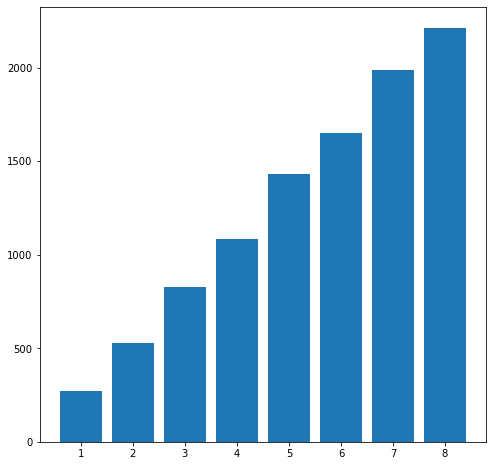

In [69]:
# b)
import matplotlib.pyplot as plt
xes = my_rolls.keys()
yes = my_rolls.values()
plt.figure(figsize=(8,8))
plt.bar(xes, yes)

In [70]:
# c)
import time

def modified_dice():
    sides = [1, 2, 3, 4, 5, 6, 7, 8]
    weights = [1, 2, 3, 4, 5, 6, 7, 8]
    start = time.time()
    results = set()
    counter = 0
    while len(results) < 8:
        r= random.choices(sides, weights=weights, k=1)[0]
        results.add(r)
        yield r
        counter += 1
    time_taken = time.time()- start
    return [counter, time_taken]

mod = modified_dice()

try:
    while True:
        next(mod)
except StopIteration as ex:
    print(f"Rolls are over. There were {ex.value[0]} throws made which took {ex.value[1]}")

Rolls are over. There were 13 throws made which took 0.0


### 2. A ticket to the first Class    

+ Create a Class called "Elevator". Each instance of this class receives as parameters the number of floors in the building and starts the elevator on the lowest floor.  
+ This Class should have methods and properties to allow the elevator to:
<br></br>
    + XReceive a call - user(s) press a button to go to specific floor(s);  
    + XReceive a floor as a destination - when users enter the elevator, each one may press a button to choose destination floor;  
    + XStore and inform which floor the elevator is at each moment(consider that trips for consecutive floors takes 5 seconds, and stopping takes 10 seconds);  
    + XStore and inform which users are in the elevator;  
    + XStore and inform the sequence of floors yet to be visited;  
    + XStore the number of times the elevator stopped in each floor (passing through the floor without "stopping" on the floor does not count);  
    + XRefuses commands to go to inexistent floors.  
<br></br>
+ Simulate the behavior of the elevator serving ten users, each one calling from a random floor, and chosing a random destination floor.   
+ Graphically illustrate the current elevator position for the requested simulation.   
+ (BONUS) Create a smart building simulator, controlling calls made to n > 1 elevators and routing elevator properly.  

In [142]:
import time
import random
from IPython.display import clear_output
    
class Elevator:
    def __init__(self, bottom, top, current):
        self.bottom = bottom
        self.top = top
        self.current = bottom
        
        self.floor_dict = {floor: 0 for floor in range(bottom, top+1)}
        self.passed_floors = []
        self.future_stops = []
        self.users = []
        self.calling_users = []
        
        self.switchScheduled = False
        self.print_elevator(self.current)

    def call(self, user):
        self.calling_users.append(user)
        self.log(f"Elevator called by user {user}")
        self.schedule_stop(user["enter"])
    
    def move_to_destinations(self):
        if self.switchScheduled:
            self.switch_users()
            self.switchScheduled = False
        while len(self.future_stops):
            next_stop = self.future_stops.pop(0)
            self.go_to(next_stop)
            self.floor_dict[next_stop] += 1
            self.switch_users()
            self.print_elevator(self.current)
            
    def schedule_stop(self, floor, high_prio=False):
        if floor not in range(self.bottom, self.top+1):
            print("This floor does not exist")
            return
        if floor != self.current:
            if high_prio:
                if floor in self.future_stops:
                    self.future_stops.remove(floor)
                self.future_stops.insert(0, floor)
            else:
                self.future_stops.append(floor)
            self.log(f"Button pushed. Future stops: {self.future_stops}")
        else:
            self.switchScheduled = True
            self.log(f"Button pushed. Already on target floor: {self.current}")
    
    def switch_users(self):
        self.log(f"Opening doors on floor {self.current}")
        calling_users_to_remove = []
        for user in self.calling_users:
            if user["enter"] == self.current:
                calling_users_to_remove.append(user)
                self.users.append(user)
                self.schedule_stop(user["destination"], True)
        for user in calling_users_to_remove:
            self.calling_users.remove(user)
                
        users_to_remove = []
        for user in self.users:
            if user["destination"] == self.current:
                users_to_remove.append(user)
        for user in users_to_remove:
            self.users.remove(user)
        time.sleep(10)
        self.log(f"Closing doors")
        self.log(f"Current passengers: {self.users}")
        
    def go_to(self, floor):
        if self.current == floor:
            self.log(f"Already on target floor {floor}")
            return
        self.log(f"Going to floor {floor}")
        while self.current != floor:
            self.log(f"Current floor: {self.current}")
            self.passed_floors.append(self.current)
            if self.current > floor:
                self.current -= 1
            elif floor > self.current:
                self.current += 1
            time.sleep(5)
            
    def log(self, message):
        print(message)
        1 + 2
        
    def print_elevator(self, floor):
        #clear_output(wait=True)
        print(f"Floor: {floor}")
        
        
top = 7
bottom = 0
elevator = Elevator(bottom, top, 0)

users = [{"name": "Hippidy", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)}, 
         {"name": "Hoppidy", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)}, 
         {"name": "Humpty", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)}, 
         {"name": "Dumpty", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)},
         {"name": "Hups", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)}, 
         {"name": "Herold", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)}, 
         {"name": "Grete", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)}, 
         {"name": "Bertha", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)},
         {"name": "Gertrude", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)}, 
         {"name": "Christa", "enter": random.randint(bottom, top), "destination": random.randint(bottom, top)}]

for user in users:
    elevator.call(user)

elevator.move_to_destinations()

Floor: 0
Elevator called by user {'name': 'Hippidy', 'enter': 0, 'destination': 1}
Button pushed. Already on target floor: 0
Elevator called by user {'name': 'Hoppidy', 'enter': 6, 'destination': 5}
Button pushed. Future stops: [6]
Elevator called by user {'name': 'Humpty', 'enter': 6, 'destination': 0}
Button pushed. Future stops: [6, 6]
Elevator called by user {'name': 'Dumpty', 'enter': 4, 'destination': 7}
Button pushed. Future stops: [6, 6, 4]
Elevator called by user {'name': 'Hups', 'enter': 1, 'destination': 3}
Button pushed. Future stops: [6, 6, 4, 1]
Elevator called by user {'name': 'Herold', 'enter': 0, 'destination': 3}
Button pushed. Already on target floor: 0
Elevator called by user {'name': 'Grete', 'enter': 1, 'destination': 5}
Button pushed. Future stops: [6, 6, 4, 1, 1]
Elevator called by user {'name': 'Bertha', 'enter': 5, 'destination': 4}
Button pushed. Future stops: [6, 6, 4, 1, 1, 5]
Elevator called by user {'name': 'Gertrude', 'enter': 7, 'destination': 1}
Button